In [1]:
import pandas as pd
from openpyxl import load_workbook
import seaborn as sns
import matplotlib.pyplot as plt

def output_generator(filepath,n_customer=10):
    def float2percent(num):
        num2 = str(int(num))
        string = num2 + '%'
        return string

    def map_solution(rootcause):
        case_1 = [
            'Kokenktor putus',
            'Core Crack/Bending',
            'Konektor Rusak',
            'Kabel DW Rusak',
            'Patchcore Rusak',
            'putus kabel',
            'FO CUT',		
            'Patchcore rusak',
            'konektor longgar',
            'Konektor longgar',
            'Putus Kabel',
            'FO Cut',
            'Kabel kebakar',
            'Konektor Lepas Di FAT (ARISAN)'
        ]

        case_2 = [
            'Bad Performance Perangkat',
            'Adaptor rusak',
            'Adaptor Rusak'		
        ]

        case_3 = [
            'Kendala OLT',
            'Masalah di splitter',
            'Masalah di Splitter',
            'Kendala di OLT',		
            'FAT Down',
            'FAT Broken',
            'FDT Broken',
            'PSU',
            'MCB Trip',
            'Kabel ngandong'
        ]

        case_4 = [
            'Kabel dw terjepit',
            'kabel terjepit',
            'Kabel Terjepit',
            'Konektor lepas di FAT',		
            'pigtail ketekuk',
            'DW Bending',
            'dw bending / ketekuk',
            'Kabel DW terjepit'
        ]

        if rootcause in case_1:
            return 'Penarikan Kabel Baru'
        elif rootcause in case_2:
            return 'Penggantian/perbaikan set perangkat'
        elif rootcause in case_3:
            return 'Preventive maintenance, lakukan pengecekan berkala'
        elif rootcause in case_4:
            return 'Pengawasan SOP Pekerjaan'
        else:
            return '-'
        
    def visualize(df):
        # Calculating the occurrences of each customer
        customer_occurrences = df['customer'].value_counts()

        # Getting the top 10 recurring customers based on total number of incidents
        top_customers = customer_occurrences.head(10).index

        # Filtering the data for these top recurring customers
        top_customers_data = df[df['customer'].isin(top_customers)]

        # Grouping by customer and rootcause and counting occurrences
        root_causes_for_top_customers = top_customers_data.groupby(['customer', 'rootcause']).size().reset_index(name='count')

        # Calculating the total number of incidents per customer
        total_incidents_per_customer = root_causes_for_top_customers.groupby('customer')['count'].sum().reset_index(name='total_incidents')

        # Merging total incidents data with root cause data
        merged_data = pd.merge(root_causes_for_top_customers, total_incidents_per_customer, on='customer')

        # Sorting by total incidents and then by customer in descending order
        sorted_top_customers_root_causes = merged_data.sort_values(by=['total_incidents', 'customer'], ascending=[False, True])

        # Plotting
        plt.figure(figsize=(15, 10))
        sns.barplot(x='count', y='customer', hue='rootcause', data=sorted_top_customers_root_causes, palette='viridis')
        plt.title('Top Recurring Customers and Their Root Causes')
        plt.xlabel('Number of Incidents')
        plt.ylabel('Customer')
        plt.legend(title='Root Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()

        plt.show()

    # Step 1: Load your data into a pandas DataFrame
    df = pd.read_excel(filepath,index_col=0)
    df.dropna(subset=['customer-kota','rootcause'],inplace=True)
    df.drop(columns=['time_up','time_down','incident_id'], inplace=True)

    df2 = df.copy()
    df2['count'] = df.groupby('customer-kota')['customer-kota'].transform('count')
    df3 = df2.drop_duplicates(subset='customer-kota')
    df4 = df3[['customer-kota','count']].sort_values(by='customer-kota').nlargest(n_customer,columns=['count'])
    df = df[df['customer-kota'].isin(df4['customer-kota'])]

    # Step 2: Create a new column that we need
    df['count'] = df.groupby('customer-kota')['rootcause'].transform('size')
    df['rootcause_percent'] = (
        df.groupby(by = ['rootcause', 'customer-kota'])['customer-kota'].transform('count') / 
        df['count'] * 100
        ).apply(float2percent)
    df['solution'] = df['rootcause'].apply(map_solution)

    # Step 3: Save the 'customer-kota'
    df.drop_duplicates(inplace=True)

    # First, let's sort the DataFrame based on the 'count' column in descending order
    df5_sorted = df.sort_values(by=['count','customer-kota'], ascending=[False,True])

    # Now, we can group by 'count' and 'customer' and print the groups in descending order
    grouping =  df5_sorted.groupby(['count', 'customer-kota'], sort=False)

    # Step 4: Drop unnecessary Columns and Rows
    df = df5_sorted[['customer','kab/kota','rootcause','rootcause_percent','solution', 'count']]
    visualize(df)
    # Step 5: Export to Excel without the index
    path_baru = filepath.replace('.xlsx',f'_merged_{n_customer}.xlsx')
    df.to_excel(path_baru, index=False)

    # Step 6: Use openpyxl to merge cells for 'customer-kota'
    wb = load_workbook(path_baru)
    ws = wb.active

    # Assuming that 'customer-kota' is in column B (index 2)
    start_row = 2
    start_column, end_column = 1,1
    for name, group in grouping:
        size = len(group)
        end_row = start_row + size - 1
        ws.merge_cells(start_row=start_row, start_column=start_column, end_row=end_row, end_column=end_column)
        start_row = end_row + 1

    # Save the workbook
    wb.save(path_baru)


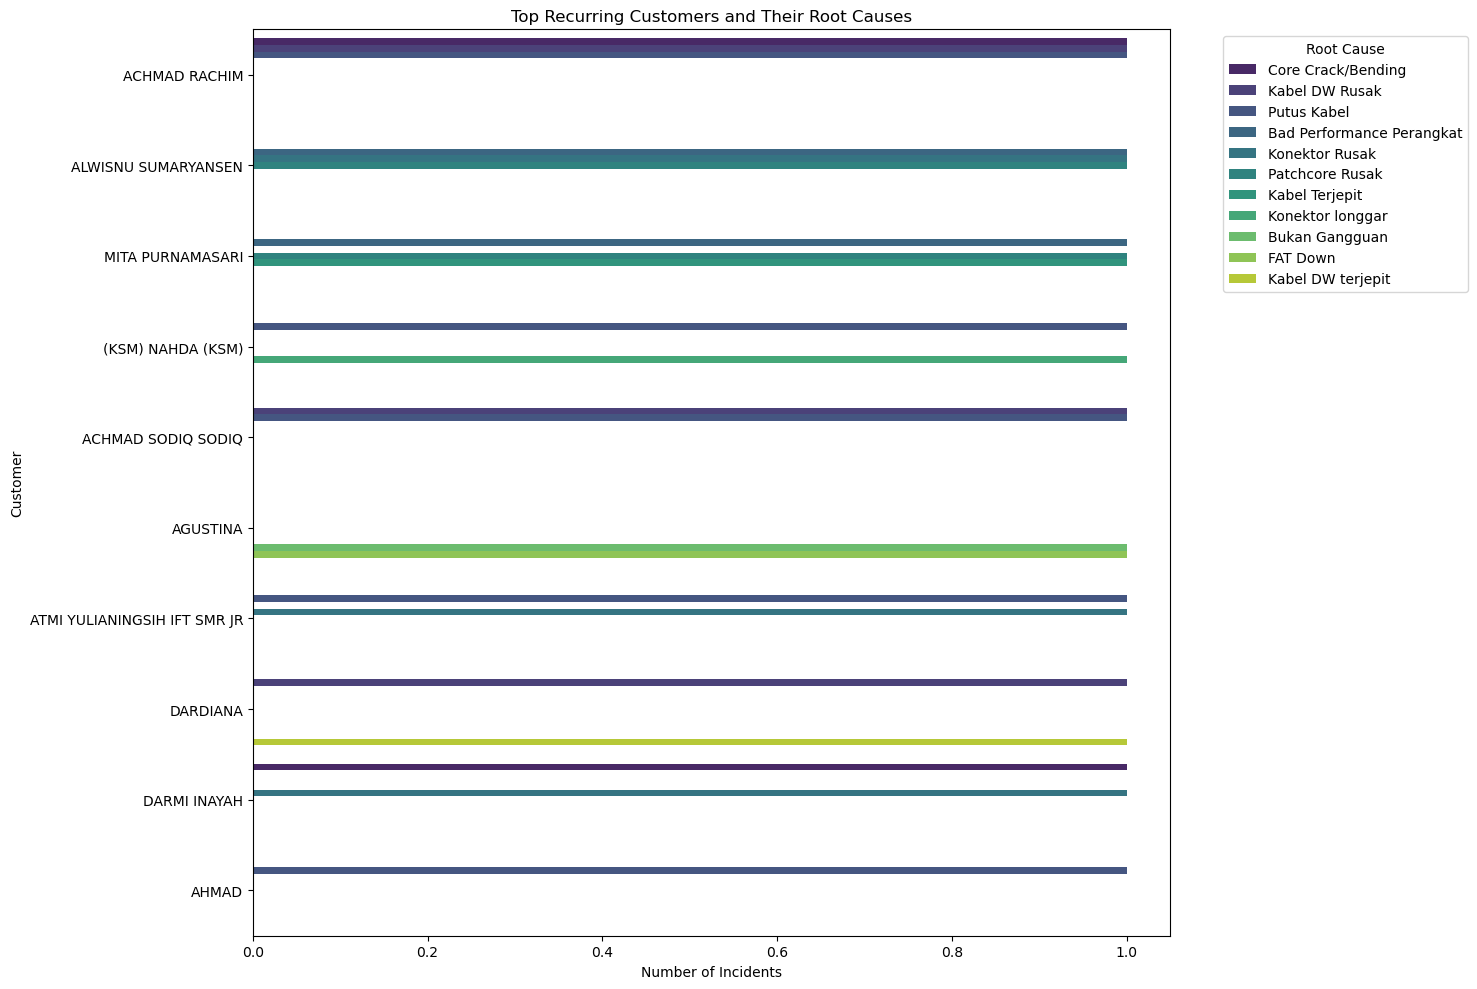

In [2]:
file_path = r'data/KALTIM_clean.xlsx' # Definisikan lokasi file yang ingin disajikan (gunakan file yang clean dan sudah dibersihkan)
top_customers = 10 # Definisikan jumlah top customer yang ingin disajikan

output_generator(file_path,top_customers)